In [1]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp
from pyspark.sql import Window
spark = SparkSession.builder.appName('eda elevator').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [2]:
 data_schema = types.StructType([
    types.StructField('Timestamp', types.StringType()),
    types.StructField('AccelerationX', types.DoubleType()),
    types.StructField('AccelerationY', types.DoubleType()),
    types.StructField('AccelerationZ', types.DoubleType())
    ])

In [3]:
df = spark.read.csv("/home/riat/sfuhome/EDS_7.csv/EDS_7.csv",schema=data_schema)

In [4]:
df_filter = df.where((df['Timestamp']>='2018-07-09 12:00:00') & (df['Timestamp']<='2018-07-30 12:00:00'))

In [5]:
# Apply Z- Normalization 

unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["AccelerationZ"],
    outputCol="Zvector")
tempdata = assembler.transform(df_filter)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()

In [6]:
# Strip the timestamp to seconds
scaledData = scaledData.withColumn("Timestamp1", to_timestamp("Timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()

In [7]:
movAvg = scaledData.withColumn("movingAverage", functions.avg(scaledData["Zscale"])
             .over(Window.partitionBy(scaledData["timestamp1"]).rowsBetween(-1,1))).cache()

In [8]:
find_mode = scaledData.withColumn("Frequency", functions.round(scaledData["Zscale"], 0))

In [9]:
count_zscale = find_mode.groupby(find_mode['Frequency']).count()

In [10]:
count_zscale.toPandas().to_csv('/home/riat/sfuhome/EDA7_frequency.csv')

In [11]:
# Find out the timestamp using the mode
find_sample = find_mode.where(find_mode['Frequency']==11) 
find_sample.show()

+--------------------+-------------+-------------+-------------+---------+-------------------+---------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|   Zscale|         Timestamp1|Frequency|
+--------------------+-------------+-------------+-------------+---------+-------------------+---------+
|2018-07-09 12:01:...|     0.015625|    -0.042969|     0.988281|10.849237|2018-07-09 12:01:21|     11.0|
|2018-07-09 12:06:...|     0.011719|    -0.046875|     0.984375|10.502469|2018-07-09 12:06:12|     11.0|
|2018-07-09 12:07:...|     0.015625|    -0.042969|     0.992188|11.196095|2018-07-09 12:07:44|     11.0|
|2018-07-09 12:08:...|     0.015625|    -0.042969|     0.988281|10.849237|2018-07-09 12:08:19|     11.0|
|2018-07-09 12:09:...|     0.015625|    -0.046875|     0.984375|10.502469|2018-07-09 12:09:49|     11.0|
|2018-07-09 12:10:...|     0.011719|    -0.042969|     0.988281|10.849237|2018-07-09 12:10:15|     11.0|
|2018-07-09 12:10:...|     0.007813|    -0.039063|     

In [9]:
# RawData anomaly detection 

df_sort = scaledData.sort(col("Zscale").desc())
df_sort.show()

+--------------------+-------------+-------------+-------------+---------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|   Zscale|         Timestamp1|
+--------------------+-------------+-------------+-------------+---------+-------------------+
|2018-07-10 19:19:...|     0.003906|    -0.105469|     1.328125| 40.67987|2018-07-10 19:19:46|
|2018-07-14 16:00:...|     0.015625|    -0.046875|     1.316406|39.648869|2018-07-14 16:00:31|
|2018-07-13 16:47:...|     0.042969|     0.070313|      1.28125|36.555954|2018-07-13 16:47:32|
|2018-07-14 16:00:...|     0.011719|    -0.039063|     1.277344|36.212317|2018-07-14 16:00:32|
|2018-07-14 16:00:...|     0.003906|    -0.046875|     1.230469|32.088401|2018-07-14 16:00:31|
|2018-07-14 15:04:...|     0.023438|    -0.042969|     1.195313|28.995487|2018-07-14 15:04:19|
|2018-07-14 12:49:...|    -0.039063|    -0.011719|       1.1875|28.308123|2018-07-14 12:49:42|
|2018-07-14 15:04:...|     0.015625|    -0.050781|

In [93]:
df_sort = scaledData.sort(col("Zscale"))
df_sort.show()

+--------------------+-------------+-------------+-------------+----------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|    Zscale|         Timestamp1|
+--------------------+-------------+-------------+-------------+----------+-------------------+
|2018-07-09 19:35:...|    -0.085938|    -0.007813|     0.363281| -44.20408|2018-07-09 19:35:21|
|2018-07-14 19:36:...|     0.164063|    -0.011719|     0.457031|-35.956249|2018-07-14 19:36:56|
|2018-07-12 00:51:...|    -0.050781|    -0.042969|     0.546875|-28.052056|2018-07-12 00:51:45|
|2018-07-10 12:41:...|     0.066406|    -0.027344|        0.625|-21.178863|2018-07-10 12:41:54|
|2018-07-10 12:41:...|       0.0625|    -0.050781|     0.632813|  -20.4915|2018-07-10 12:41:52|
|2018-07-10 12:41:...|     0.050781|    -0.039063|     0.640625|-19.804224|2018-07-10 12:41:57|
|2018-07-10 12:41:...|     0.058594|    -0.019531|     0.640625|-19.804224|2018-07-10 12:41:51|
|2018-07-10 12:41:...|     0.050781|    

In [68]:
# RawData anomaly detection 

df_sort_mov = movAvg.sort(col("movingAverage").desc())
df_sort_mov.show()

+--------------------+-------------+-------------+-------------+---------+-------------------+------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|   Zscale|         Timestamp1|     movingAverage|
+--------------------+-------------+-------------+-------------+---------+-------------------+------------------+
|2018-07-14 16:00:...|     0.015625|    -0.046875|     1.316406|39.648869|2018-07-14 16:00:31|         35.868635|
|2018-07-14 16:00:...|     0.011719|    -0.039063|     1.277344|36.212317|2018-07-14 16:00:32|         30.541944|
|2018-07-14 16:00:...|     0.003906|    -0.046875|     1.230469|32.088401|2018-07-14 16:00:31|          29.45367|
|2018-07-14 15:04:...|     0.023438|    -0.042969|     1.195313|28.995487|2018-07-14 15:04:19|26.475301666666667|
|2018-07-14 15:04:...|     0.015625|    -0.050781|     1.171875|26.933485|2018-07-14 15:04:19|         25.215209|
|2018-07-14 16:00:...|     0.011719|    -0.042969|     1.148438|24.871571|2018-07-14 16:

In [94]:
# RawData anomaly detection 

df_sort_mov = movAvg.sort(col("movingAverage"))
df_sort_mov.show()

+--------------------+-------------+-------------+-------------+----------+-------------------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|    Zscale|         Timestamp1|      movingAverage|
+--------------------+-------------+-------------+-------------+----------+-------------------+-------------------+
|2018-07-09 19:35:...|    -0.085938|    -0.007813|     0.363281| -44.20408|2018-07-09 19:35:21|-21.866167666666666|
|2018-07-09 19:35:...|     0.136719|     0.628906|     0.683594|-16.023947|2018-07-09 19:35:21| -19.91877033333333|
|2018-07-09 19:35:...|    -0.105469|    -0.035156|     0.804688| -5.370476|2018-07-09 19:35:21|-16.711280333333335|
|2018-07-14 13:08:...|     0.011719|    -0.054688|     0.683594|-16.023947|2018-07-14 13:08:22|         -15.222096|
|2018-07-14 13:08:...|     0.007813|    -0.050781|     0.691406|-15.336671|2018-07-14 13:08:22|-14.992975000000001|
|2018-07-14 15:35:...|     0.011719|    -0.042969|     0.691406|-15.3366

### Anomaly 1 

In [69]:
df_check = scaledData.where((scaledData['Timestamp']>='2018-07-14 16:00:00') & (scaledData['Timestamp']<='2018-07-14 16:01:00'))

CPU times: user 115 ms, sys: 588 µs, total: 116 ms
Wall time: 421 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-14 16:00:32')

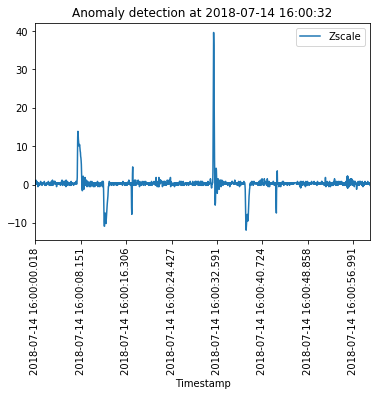

In [75]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-14 16:00:32')

In [71]:
df_check_mov = movAvg.where((movAvg['Timestamp1']>='2018-07-14 16:00:00') & (movAvg['Timestamp1']<='2018-07-14 16:01:00'))

CPU times: user 123 ms, sys: 13.7 ms, total: 137 ms
Wall time: 3.85 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-14 16:00:32')

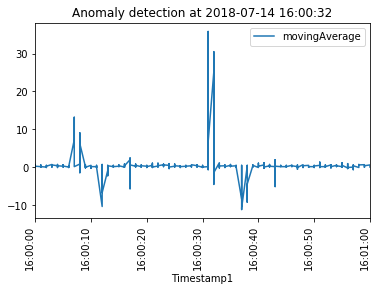

In [76]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-14 16:00:32')

### Anomaly 2

In [77]:
df_check = scaledData.where((scaledData['Timestamp']>='2018-07-13 16:47:00') & (scaledData['Timestamp']<='2018-07-13 16:48:00'))

CPU times: user 114 ms, sys: 4.37 ms, total: 119 ms
Wall time: 499 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

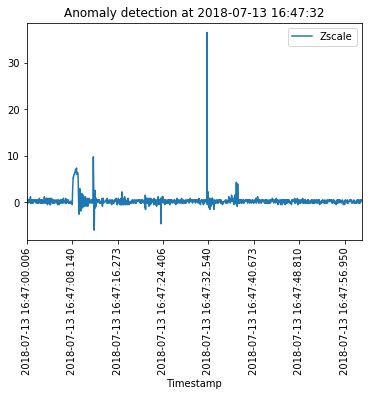

In [81]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-13 16:47:32')

In [79]:
df_check_mov = movAvg.where((movAvg['Timestamp1']>='2018-07-13 16:47:00') & (movAvg['Timestamp1']<='2018-07-13 16:48:00'))

CPU times: user 130 ms, sys: 5.86 ms, total: 136 ms
Wall time: 4.29 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

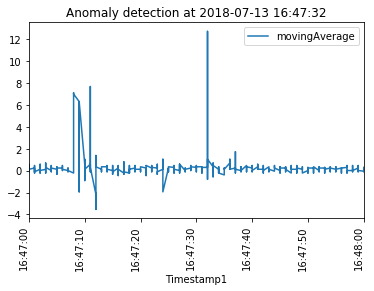

In [82]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-13 16:47:32')

### Anomaly 3

In [85]:
df_check = scaledData.where((scaledData['Timestamp']>='2018-07-10 12:41:00') & (scaledData['Timestamp']<='2018-07-10 12:43:00'))

CPU times: user 227 ms, sys: 1.74 ms, total: 229 ms
Wall time: 520 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

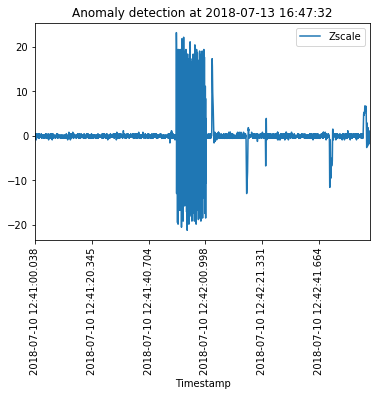

In [86]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-10 12:42:41')

In [90]:
df_check_mov = movAvg.where((movAvg['Timestamp1']>='2018-07-10 12:41:00') & (movAvg['Timestamp1']<='2018-07-10 12:43:00'))

CPU times: user 250 ms, sys: 5.45 ms, total: 256 ms
Wall time: 5.44 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

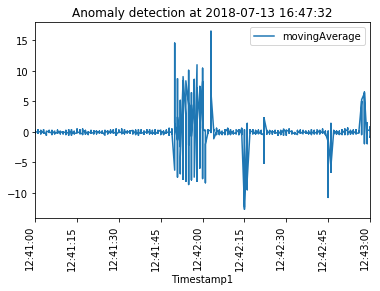

In [91]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-10 12:42:41'')

### Anomaly 4 

In [95]:
df_check = scaledData.where((scaledData['Timestamp']>='2018-07-09 19:35:00') & (scaledData['Timestamp']<='2018-07-09 19:36:00'))

CPU times: user 116 ms, sys: 3.49 ms, total: 119 ms
Wall time: 590 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

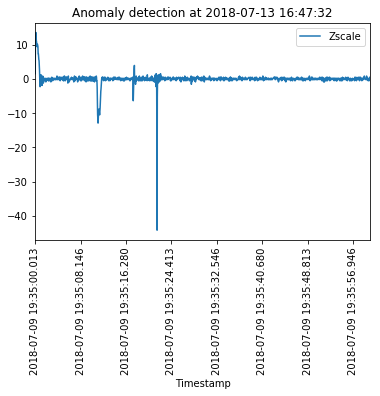

In [96]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 19:35:00')

In [97]:
df_check_mov = movAvg.where((movAvg['Timestamp1']>='2018-07-09 19:35:00') & (movAvg['Timestamp1']<='2018-07-09 19:36:00'))

CPU times: user 136 ms, sys: 6.28 ms, total: 142 ms
Wall time: 6.46 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-13 16:47:32')

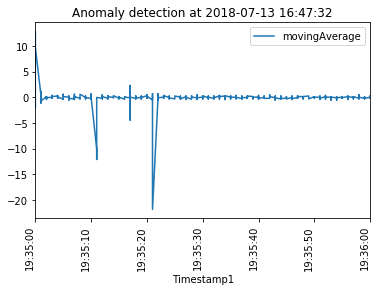

In [98]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 19:35:00')

### Anomaly 5

CPU times: user 275 ms, sys: 14.4 ms, total: 289 ms
Wall time: 744 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 19:35:00')

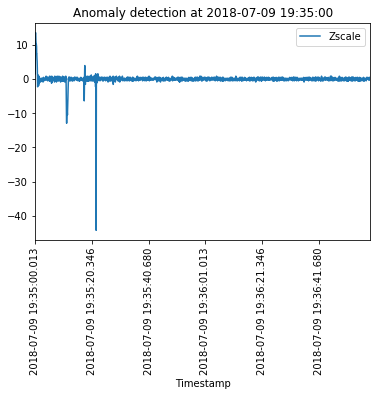

In [103]:
df_check = scaledData.where((scaledData['Timestamp']>='2018-07-09 19:35:00') & (scaledData['Timestamp']<='2018-07-09 19:37:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 19:35:00')

CPU times: user 240 ms, sys: 1.75 ms, total: 241 ms
Wall time: 6.41 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 19:35:00')

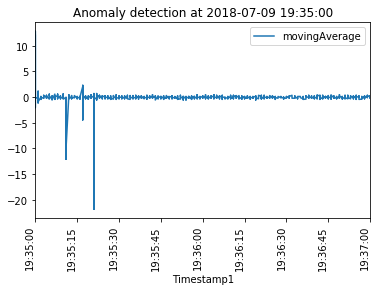

In [104]:
df_check_mov = movAvg.where((movAvg['Timestamp1']>='2018-07-09 19:35:00') & (movAvg['Timestamp1']<='2018-07-09 19:37:00'))

# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 19:35:00')

From dates 2018-07-16 12:00:00 to 2018-07-24 12:00:00

In [4]:
df_filter2 = df.where((df['Timestamp']>='2018-07-16 12:00:00') & (df['Timestamp']<='2018-07-24 12:00:00'))

In [5]:
# Apply Z- Normalization 

unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["AccelerationZ"],
    outputCol="Zvector")
tempdata = assembler.transform(df_filter2)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData2 = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()

In [6]:
# Strip the timestamp to seconds
scaledData2 = scaledData2.withColumn("Timestamp1", to_timestamp("Timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()

In [7]:
movAvg2 = scaledData2.withColumn("movingAverage", functions.avg(scaledData2["Zscale"])
             .over(Window.partitionBy(scaledData2["timestamp1"]).rowsBetween(-1,1))).cache()

In [8]:
df_sort2 = scaledData2.sort(col("Zscale").desc())
df_sort2.show()

+--------------------+-------------+-------------+-------------+---------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|   Zscale|         Timestamp1|
+--------------------+-------------+-------------+-------------+---------+-------------------+
|2018-07-20 22:43:...|       -0.875|         -2.0|     1.996094|97.184695|2018-07-20 22:43:20|
|2018-07-16 21:07:...|    -0.179688|      -0.5625|     1.402344|46.130185|2018-07-16 21:07:39|
|2018-07-16 16:02:...|     0.015625|    -0.050781|      1.34375|41.091889|2018-07-16 16:02:14|
|2018-07-16 16:02:...|     0.011719|    -0.042969|     1.316406|38.740673|2018-07-16 16:02:14|
|2018-07-16 16:02:...|     0.007813|    -0.042969|     1.242188|32.358924|2018-07-16 16:02:14|
|2018-07-22 19:51:...|    -0.277344|    -0.257813|     1.222656|30.679435|2018-07-22 19:51:25|
|2018-07-16 16:02:...|     0.011719|    -0.046875|       1.1875|27.656492|2018-07-16 16:02:14|
|2018-07-17 23:54:...|    -0.066406|    -0.199219|

In [9]:
df_sort_mov2 = movAvg2.sort(col("movingAverage").desc())
df_sort_mov2.show()

+--------------------+-------------+-------------+-------------+---------+-------------------+------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|   Zscale|         Timestamp1|     movingAverage|
+--------------------+-------------+-------------+-------------+---------+-------------------+------------------+
|2018-07-16 16:02:...|     0.015625|    -0.050781|      1.34375|41.091889|2018-07-16 16:02:14|         37.397162|
|2018-07-16 16:02:...|     0.011719|    -0.042969|     1.316406|38.740673|2018-07-16 16:02:14| 35.82968466666667|
|2018-07-20 22:43:...|       -0.875|         -2.0|     1.996094|97.184695|2018-07-20 22:43:20| 33.03067933333333|
|2018-07-20 22:43:...|      0.03125|    -0.132813|     0.886719| 1.793373|2018-07-20 22:43:20|32.358895000000004|
|2018-07-20 22:43:...|     0.019531|    -0.042969|     0.867188|  0.11397|2018-07-20 22:43:20|32.134986000000005|
|2018-07-16 16:02:...|     0.007813|    -0.042969|     1.242188|32.358924|2018-07-16 16:

In [10]:
df_sort2 = scaledData2.sort(col("Zscale"))
df_sort2.show()

+--------------------+-------------+-------------+-------------+-----------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|     Zscale|         Timestamp1|
+--------------------+-------------+-------------+-------------+-----------+-------------------+
|2018-07-22 20:46:...|    -0.175781|     0.863281|    -0.691406|-133.904142|2018-07-22 20:46:00|
|2018-07-16 19:49:...|     0.117188|     0.597656|      0.28125| -50.268814|2018-07-16 19:49:27|
|2018-07-19 07:32:...|     0.054688|     0.011719|     0.472656| -33.810474|2018-07-19 07:32:07|
|2018-07-21 18:45:...|    -0.011719|       -0.125|       0.5625| -26.085098|2018-07-21 18:45:18|
|2018-07-19 10:03:...|     0.089844|    -0.070313|       0.5625| -26.085098|2018-07-19 10:03:46|
|2018-07-21 00:56:...|     0.011719|     0.035156|     0.578125| -24.741559|2018-07-21 00:56:23|
|2018-07-21 05:28:...|     0.007813|    -0.058594|      0.59375| -23.398019|2018-07-21 05:28:20|
|2018-07-22 20:46:...|      0.

In [11]:
df_sort_mov2 = movAvg2.sort(col("movingAverage"))
df_sort_mov2.show()

+--------------------+-------------+-------------+-------------+-----------+-------------------+-------------------+
|           Timestamp|AccelerationX|AccelerationY|AccelerationZ|     Zscale|         Timestamp1|      movingAverage|
+--------------------+-------------+-------------+-------------+-----------+-------------------+-------------------+
|2018-07-22 20:46:...|      0.03125|    -0.367188|     0.605469| -22.390343|2018-07-22 20:46:00|-52.620001333333335|
|2018-07-22 20:46:...|    -0.175781|     0.863281|    -0.691406|-133.904142|2018-07-22 20:46:00|-52.172155000000004|
|2018-07-22 20:46:...|     0.011719|    -0.046875|     0.863281|   -0.22198|2018-07-22 20:46:00| -44.44680833333334|
|2018-07-16 19:49:...|     0.117188|     0.597656|      0.28125| -50.268814|2018-07-16 19:49:27|         -25.077422|
|2018-07-18 15:11:...|     0.003906|    -0.054688|     0.652344| -18.359723|2018-07-18 15:11:54|-17.575984666666667|
|2018-07-18 15:11:...|     0.007813|    -0.042969|     0.664063|

### Anomaly 6

CPU times: user 362 ms, sys: 6.6 ms, total: 368 ms
Wall time: 1.1 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 22:43:15')

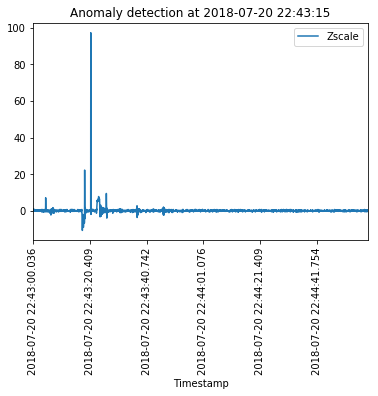

In [12]:
df_check2 = scaledData2.where((scaledData2['Timestamp']>='2018-07-20 22:43:00') & (scaledData2['Timestamp']<='2018-07-20 22:45:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas2 = df_check2.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 22:43:15')

CPU times: user 248 ms, sys: 157 µs, total: 248 ms
Wall time: 6.71 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 22:43:15')

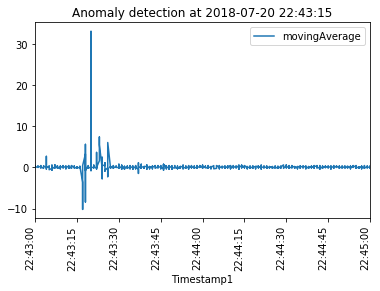

In [13]:
df_check_mov2 = movAvg2.where((movAvg2['Timestamp1']>='2018-07-20 22:43:00') & (movAvg2['Timestamp1']<='2018-07-20 22:45:00'))

# Convert to Pandas and plot

%time temp_pandas3 = df_check_mov2.select("*").toPandas()
temp_pandas3.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 22:43:15')

### Anomaly 7

CPU times: user 250 ms, sys: 1.92 ms, total: 252 ms
Wall time: 824 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-18 21:07:35')

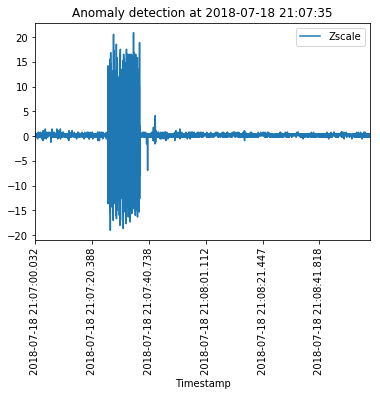

In [14]:
df_check2 = scaledData2.where((scaledData2['Timestamp']>='2018-07-18 21:07:00') & (scaledData2['Timestamp']<='2018-07-18 21:09:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas2 = df_check2.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-18 21:07:35')

CPU times: user 251 ms, sys: 2.11 ms, total: 254 ms
Wall time: 7.06 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-18 21:07:35')

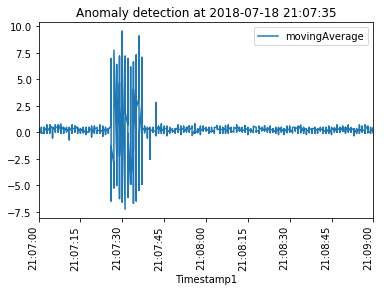

In [15]:
df_check_mov2 = movAvg2.where((movAvg2['Timestamp1']>='2018-07-18 21:07:00') & (movAvg2['Timestamp1']<='2018-07-18 21:09:00'))

# Convert to Pandas and plot

%time temp_pandas3 = df_check_mov2.select("*").toPandas()
temp_pandas3.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-18 21:07:35')

### Anomaly 8

CPU times: user 364 ms, sys: 3.36 ms, total: 367 ms
Wall time: 831 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-22 20:46:00')

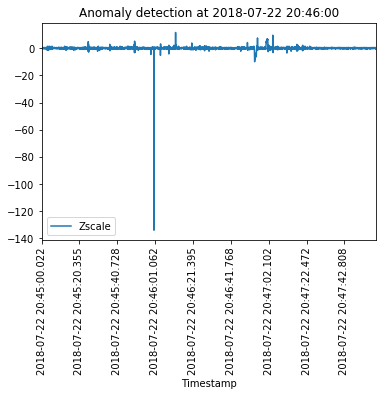

In [17]:
df_check2 = scaledData2.where((scaledData2['Timestamp']>='2018-07-22 20:45:00') & (scaledData2['Timestamp']<='2018-07-22 20:48:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas2 = df_check2.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-22 20:46:00')

CPU times: user 349 ms, sys: 8.77 ms, total: 357 ms
Wall time: 5.59 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-22 20:46:00')

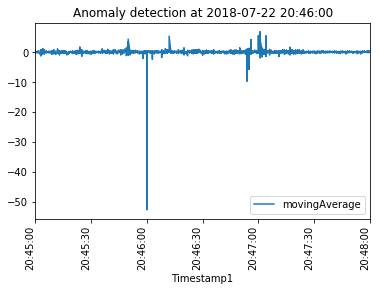

In [18]:
df_check_mov2 = movAvg2.where((movAvg2['Timestamp1']>='2018-07-22 20:45:00') & (movAvg2['Timestamp1']<='2018-07-22 20:48:00'))

# Convert to Pandas and plot

%time temp_pandas3 = df_check_mov2.select("*").toPandas()
temp_pandas3.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-22 20:46:00')

### Anomaly 9 

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 628 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-22 22:06:39')

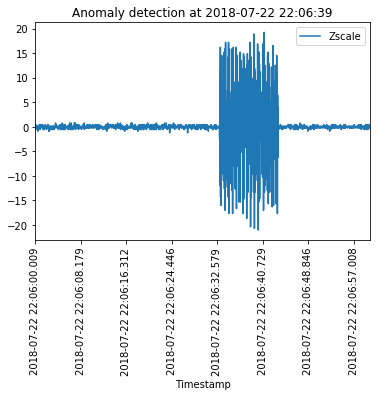

In [19]:
df_check2 = scaledData2.where((scaledData2['Timestamp']>='2018-07-22 22:06:00') & (scaledData2['Timestamp']<='2018-07-22 22:07:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas2 = df_check2.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-22 22:06:39')

CPU times: user 127 ms, sys: 7.64 ms, total: 135 ms
Wall time: 5.28 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-22 22:06:39')

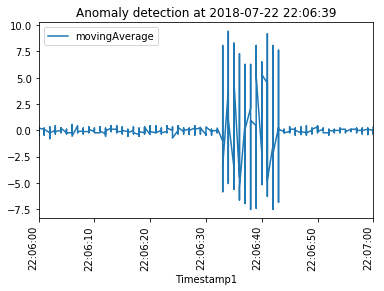

In [20]:
df_check_mov2 = movAvg2.where((movAvg2['Timestamp1']>='2018-07-22 22:06:00') & (movAvg2['Timestamp1']<='2018-07-22 22:07:00'))

# Convert to Pandas and plot

%time temp_pandas3 = df_check_mov2.select("*").toPandas()
temp_pandas3.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-22 22:06:39')

### Anomaly 10

CPU times: user 113 ms, sys: 4.3 ms, total: 118 ms
Wall time: 644 ms


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 22:43:18')

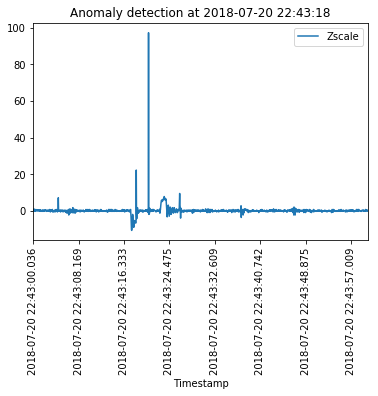

In [21]:
df_check2 = scaledData2.where((scaledData2['Timestamp']>='2018-07-20 22:43:00') & (scaledData2['Timestamp']<='2018-07-20 22:44:00'))
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas2 = df_check2.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 22:43:18')

CPU times: user 165 ms, sys: 1.31 ms, total: 167 ms
Wall time: 5.9 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 22:43:18')

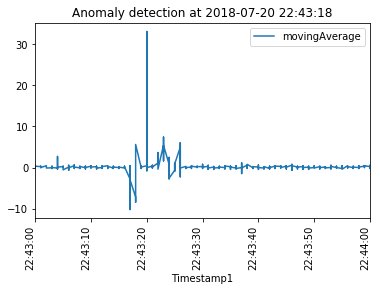

In [22]:
df_check_mov2 = movAvg2.where((movAvg2['Timestamp1']>='2018-07-20 22:43:00') & (movAvg2['Timestamp1']<='2018-07-20 22:44:00'))

# Convert to Pandas and plot

%time temp_pandas3 = df_check_mov2.select("*").toPandas()
temp_pandas3.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 22:43:18')

### Normal peaks

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 26.4 s


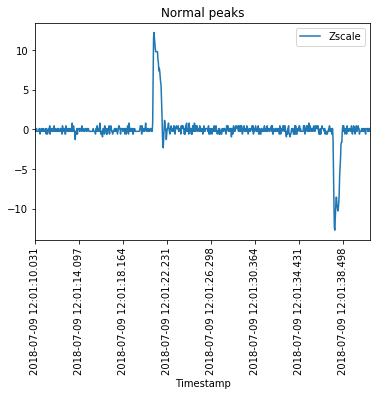

In [12]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-09 12:01:10' and '2018-07-09 12:01:40' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Normal peaks')

plt.rcParams["figure.figsize"] = [30, 5]

In [ ]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-09 12:01:40' and '2018-07-09 12:02:20' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Normal peaks')

plt.rcParams["figure.figsize"] = [30, 5]